In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
cd /opt/ml/input/level2_dkt_recsys-level2-recsys-01/

/opt/ml/input/level2_dkt_recsys-level2-recsys-01


In [3]:
train = pd.read_csv('./data/train_data.csv')
test = pd.read_csv('./data/test_data.csv')

# 1. 전체 유저에 대해 문항 번호별로 정답률의 차이가 있는가?

In [4]:
problem_number = train['assessmentItemID'].apply(lambda x: x[8:10]).map(int)
problem_number.max() # 최대 13번 문제까지 존재

13

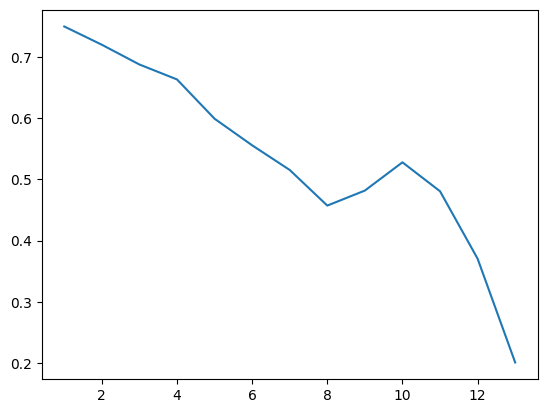

In [5]:
train['nums'] = train['assessmentItemID'].apply(lambda x: x[8:10]).map(int) # 문제 번호 column인 nums 생성
accuracy = train.groupby(['nums'])['answerCode'].mean() # 문제 번호별 정답률인 accuracy
accuracy
plt.plot(accuracy)

- 문항 번호별로 정답률의 차이 존재
- 1번에서 정답률이 가장 높고, 13번에서 정답률이 가장 낮음
- 문항번호가 커질수록 정답률이 감소하는 경향을 보임

# 2. 유저별로 푼 카테고리의 분포가 다른가? 분포상의 차이가 있는가?

In [6]:
train['cat'] = train['assessmentItemID'].apply(lambda x: x[2:3]).map(int) # 대분류 column인 cat 생성

In [7]:
catindex = train.groupby('userID')['cat'].value_counts().index # (userID, cat) multi index 형태의 key
catvalue = train.groupby('userID')['cat'].value_counts().values # [개수] 형태의 value

# multi indx를 풀기 위해서 .get_level_values() 사용
# 각 유저가 어떤 카테고리를 몇 번 만났는가?
user_cat_try = pd.DataFrame({'userID': catindex.get_level_values(0), 'cat' : catindex.get_level_values(1), 'try' : catvalue})
user_cat_try # try는 cat을 만난 홋수

,userID,cat,try
0,0,8,363
1,0,6,346
2,0,2,36
3,1,4,581
4,1,9,352
...,...,...,...
17747,7438,4,5
17748,7440,3,10
17749,7440,5,5
17750,7441,3,5


In [8]:
# 각 유저가 카테고리를 만나 어느 정도의 정답률을 보이는가?
usercatansidx = train.groupby(['userID', 'cat'])['answerCode'].mean().index
usercatansval = train.groupby(['userID', 'cat'])['answerCode'].mean().values
user_cat_ans = pd.DataFrame({'userID': usercatansidx.get_level_values(0), 'cat' : usercatansidx.get_level_values(1), 'ans' : usercatansval})
user_cat_ans # ans는 정답률을 의미하는 column

,userID,cat,ans
0,0,2,0.722222
1,0,6,0.791908
2,0,8,0.468320
3,1,4,0.822719
4,1,9,0.903409
...,...,...,...
17747,7438,8,0.666667
17748,7440,3,0.400000
17749,7440,5,0.400000
17750,7441,3,0.200000


In [9]:
# 위 두 경우를 merge
ucta = pd.merge(left = user_cat_try, right = user_cat_ans, on = ['userID', 'cat'], how = 'left')
ucta # 유저가 만난 cat 수와 그에 따른 정답률
# 실제로 1번 user는 cat 9를 만나 318번 맞고, 34번 틀림

,userID,cat,try,ans
0,0,8,363,0.468320
1,0,6,346,0.791908
2,0,2,36,0.722222
3,1,4,581,0.822719
4,1,9,352,0.903409
...,...,...,...,...
17747,7438,4,5,0.800000
17748,7440,3,10,0.400000
17749,7440,5,5,0.400000
17750,7441,3,5,0.200000


- 유저별 마주친 cat과, 이를 만났을 때의 정답률을 구함
- cat이 높은 문제(어려운 문제로 추정)를 오히려 잘 푸는 학생들도 존재
- 또한 학생들이 만나는 cat의 수가 한정적인 것이 확인됨
- 다만, sequential하게 정답률을 나타내야만 추이를 보고 feature로 사용할 수 있을 듯 (은혜 누님의 tag별 정답률과 같은 맥락)

In [10]:
userID_cat = ucta.groupby(['userID'])['cat'].apply(list).apply(str).to_dict() # user가 만나는 cat의 종류를 str 형태로 뽑음
userid = pd.DataFrame(userID_cat.keys(), columns = ['userID'])
catkind = pd.DataFrame(userID_cat.values(), columns = ['cat_kind']) # cat_kind는 마주친 cat의 종류
ucta_kind = pd.concat([userid, catkind], axis = 1) # userID별 cat_kind dataframe 생성
ucta_kind['cat_len'] = ucta_kind['cat_kind'].apply(lambda x: len(x) / 3).astype(int) # str 형태의 cat_kind를 3으로 나눠 길이에 따라 개수를 뽑는 것이 가능. cat_len column에 저장
ucta_kind # 유저가 경험한 cat 종류와 그 개수

,userID,cat_kind,cat_len
0,0,"[8, 6, 2]",3
1,1,"[4, 9]",2
2,2,"[3, 5]",2
3,5,"[8, 1, 6]",3
4,6,"[3, 4]",2
...,...,...,...
6693,7436,"[3, 5]",2
6694,7437,"[6, 4]",2
6695,7438,"[8, 3, 4]",3
6696,7440,"[3, 5]",2


In [11]:
print(ucta_kind['cat_len'].max()) # 3개
print(ucta_kind['cat_len'].min()) # 1개

print(len(ucta_kind[ucta_kind['cat_len'] == 3])) # 4458명
print(len(ucta_kind[ucta_kind['cat_len'] == 2])) # 2138명
print(len(ucta_kind[ucta_kind['cat_len'] == 1])) # 102명
# 왜 만나는 cat 수가 다른 것일까?

3
1
4458
2138
102


- 각 유저마다 1개부터 3개의 cat을 경험하였음
- 3개 경험 4458명, 2개 경험 2138명, 1개 경험 102명
- 특정한 cat의 조합을 만나는 것일까? 왜 사람마다 만나는 cat의 수가 다를까?

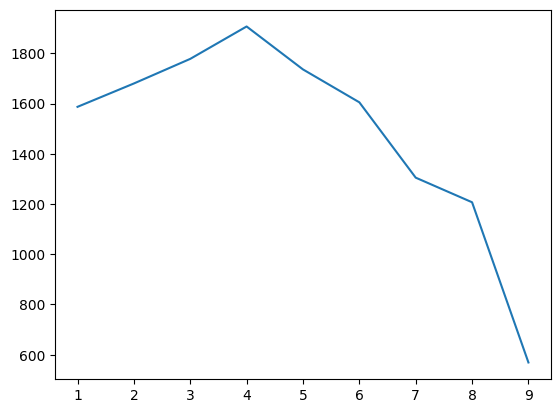

In [12]:
# 9C3의 조합 개수... 모두 보는 것은 일단 보류, 3개 cat을 보는 학생들은 어떤 cat을 가장 많이 볼까 먼저 알아보자
len3_nums = []
for i in range(1, 10):
    len3_nums.append(len(ucta_kind[(ucta_kind['cat_kind'].str.contains(f'{i}')) & (ucta_kind['cat_len'] == 3)]))
plt.plot(range(1,10), len3_nums)

- cat을 3개 만나는 학생들은 4번 cat을 가장 많이 만나고 이후 점차 감소

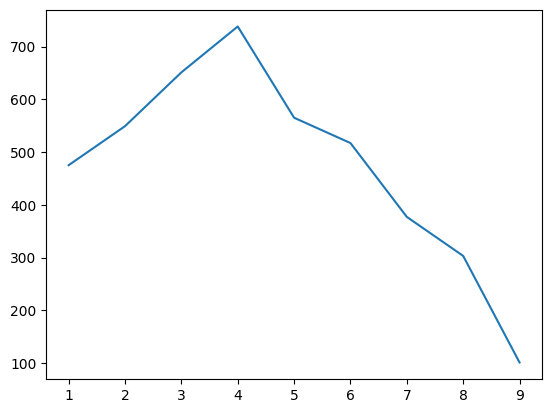

In [13]:
len2_nums = []
for i in range(1, 10):
    len2_nums.append(len(ucta_kind[(ucta_kind['cat_kind'].str.contains(f'{i}')) & (ucta_kind['cat_len'] == 2)]))
plt.plot(range(1,10), len2_nums)

- cat을 2개 만나는 학생들은 4번 cat을 가장 많이 만나고 이후 점차 감소

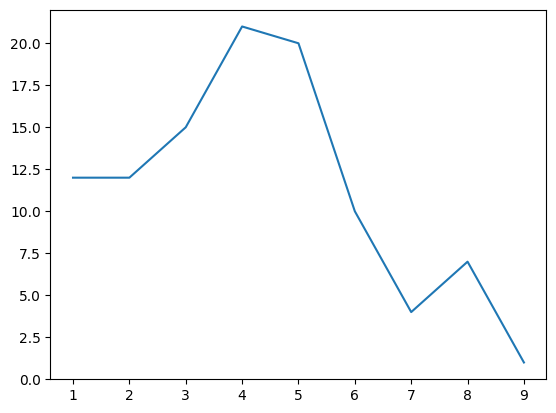

In [14]:
len1_nums = []
for i in range(1, 10):
    len1_nums.append(len(ucta_kind[(ucta_kind['cat_kind'].str.contains(f'{i}')) & (ucta_kind['cat_len'] == 1)]))
plt.plot(range(1,10), len1_nums)

- cat을 1개 만나는 학생들은 4번 cat을 가장 많이 만나고, 이후 감소하다가 8번에서 살짝 반등하였으나 큰 경향은 위 두 그래프와 동일

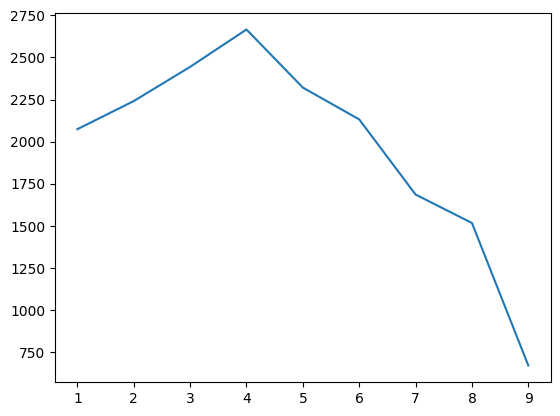

In [15]:
len_all = []
for i in range(1, 10):
    len_all.append(len(ucta_kind[(ucta_kind['cat_kind'].str.contains(f'{i}'))]))
plt.plot(range(1,10), len_all)

- 길이에 무관하게 유저가 만난 cat의 종류를 찍어 봐도 경향성은 동일함

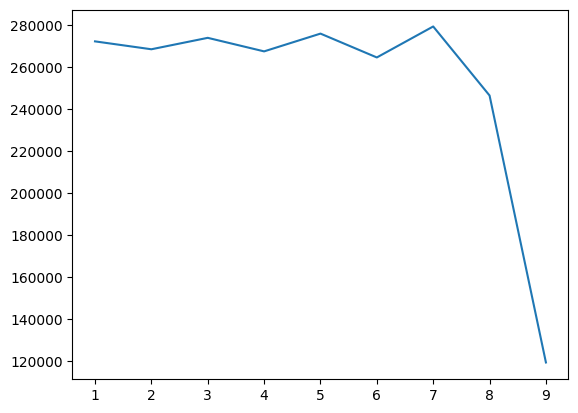

In [16]:
# 전체 train data에서 cat을 센다면?
nums = []
for i in range(1, 10):
    nums.append(len(train[train['cat'] == i]))
plt.plot(range(1,10), nums)

- train에서 cat별 수를 세보면 1-8은 거의 동일, 9번만 매우 낮은 수치임
- 하지만 유저 별로 만난 cat의 종류를 조사하면 4가 가장 높은 산봉우리 모양
- 이는 train data에서 산재되어 있는 cat이 하나로 합쳐지면서 생기는 괴리
   - ex) 1번 유저는 train data에서 cat으로 1, 1, 4, 7, 7, 7, 7 문제를 풀었음 -> 만난 cat은 [1, 4, 7] 3개
- 다만, **4번의 경우에는 웬만한 학생들에게 출제되어 수가 높지만, 다른 번호들(특히 높은 번호들)은 출제되지 않은 경우가 많아서 낮은 경향을 보임**

# 3. 출제되는 cat의 특정 조합만 나오는 것인가?

In [17]:
##### 이 부분은 필요 없습니다! 오름차순 정렬이 힘들어서 user_cat_ans로 확인을 위해 넣은 코드입니다!
aaa = user_cat_ans.groupby(['userID'])['cat'].apply(list).apply(str).to_dict()
bbb = pd.DataFrame(aaa.keys(), columns = ['userID'])
ccc = pd.DataFrame(aaa.values(), columns = ['cat_kind'])
ddd = pd.concat([bbb, ccc], axis = 1)
ddd['cat_len'] = ddd['cat_kind'].apply(lambda x: len(x) / 3).astype(int)

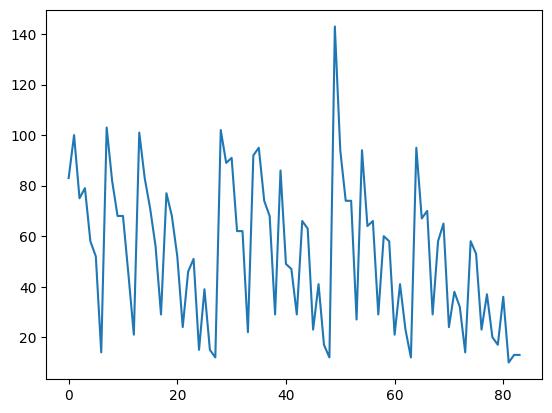

In [18]:
# 3개 cat을 마주친 학생들이 거의 동일한 cat 조합을 마주치는지 알아보자
from itertools import combinations
len3_kind = []
temp = list(combinations([1,2,3,4,5,6,7,8,9], 3))
for x in temp:
    i, j, k = str(x[0]), str(x[1]), str(x[2])
    len3_kind.append(len(ddd[(ddd['cat_kind'].str.contains(f'{i}, {j}, {k}'))]))
plt.plot(range(len(temp)), len3_kind) # 튜플 형태로 축 이름 쓸 수 없어서 번호로 바꿈

- 특정한 조합만 나오는 것은 아니지만, 모든 조합이 고른 분포로 나오는 것도 아님
   - (1,2,3)과 (1,2,4)가 나오는 횟수가 다르다는 의미
   - 잘 안 나오는 조합과 잘 나오는 조합은 확실히 구분이 됨


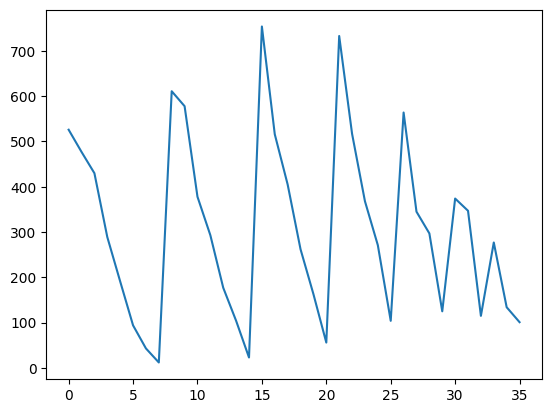

In [19]:
# 2개 cat을 마주친 학생들이 거의 동일한 cat 조합을 마주치는지 알아보자
from itertools import combinations
len2_kind = []
temp2 = list(combinations([1,2,3,4,5,6,7,8,9], 2))
for x in temp2:
    i, j= str(x[0]), str(x[1])
    len2_kind.append(len(ddd[(ddd['cat_kind'].str.contains(f'{i}, {j}'))]))
plt.plot(range(len(temp2)), len2_kind) # 튜플 형태로 축 이름 쓸 수 없어서 번호로 바꿈

- 마찬가지로 특정한 조합만 나오는 것은 아니지만, 모든 조합이 고른 분포로 나오는 것도 아님
   - 잘 나오는 조합과 잘 나오지 않는 조합의 차이가 명확함

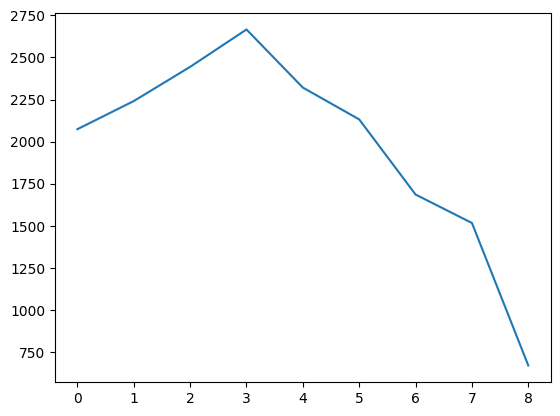

In [20]:
# 1개 cat을 마주친 학생들이 거의 동일한 cat 조합을 마주치는지 알아보자
from itertools import combinations
len1_kind = []
temp3 = list(combinations([1,2,3,4,5,6,7,8,9], 1))
for x in temp3:
    i = str(x[0])
    len1_kind.append(len(ddd[(ddd['cat_kind'].str.contains(f'{i}'))]))
plt.plot(range(len(temp3)), len1_kind) # 튜플 형태로 축 이름 쓸 수 없어서 번호로 바꿈

- 이건 당연히 위에서 이미 그린 그래프와 같음

# 4. 결론
## 1. 전체 유저에 대해 문항 번호별로 정답률의 차이가 있는가?
- 있다. 거의 명확한 선형 관계를 가짐.
- 문항 번호가 높을수록 정답률은 감소
## 2. 유저별로 푼 카테고리의 분포가 다른가? 분포상의 차이가 있는가?
- 다르다. 유저마다 1개 - 3개의 cat만 풀었음.
- 개인으로 봤을 때 cat이 높다고 해서 정답률이 떨어지지 않을 수 있음
- 유저들은 4번 cat을 가장 많이 경헝했고, 4번을 기준으로 유저들의 나머지 cat 경험 횟수는 산봉우리 형태로 감소
## 3. 출제되는 cat의 특정 조합만 나오는 것인가?
- 아니다. 모든 조합이 출제되긴 함.
- 다만, 잘 나오는 조합과 잘 나오지 않는 조합의 차이는 명확함
- 모든 조합이 출제되긴 한다는 점에서, 조합의 패턴이 있다기 보다는 단순히 1-9 cat의 출제 차이에 따른 조합의 등장 차이라고 생각됨(실제로 유저가 경험한 cat 종류와 수는 달랐기 때문)

In [21]:
train = pd.read_csv('./data/train_data.csv')
test = pd.read_csv('./data/test_data.csv')
sub = pd.read_csv('./data/sample_submission.csv')

train_origin = pd.read_csv('./data/train_data.csv')
test_origin = pd.read_csv('./data/test_data.csv')
sub_origin = pd.read_csv('./data/sample_submission.csv')

# 1. Feature Instruction
- userID 사용자의 고유번호입니다. 총 7,442명의 고유 사용자가 있으며, train/test셋은 이 userID를 기준으로 90/10의 비율로 나누어졌습니다.

- assessmentItemID 문항의 고유번호입니다. 총 9,454개의 고유 문항이 있습니다. 이 일련 번호에 대한 규칙은 DKT 2강 EDA에서 다루었으니 강의 들어보시면 좋을 것 같습니다.

- testId 시험지의 고유번호입니다. 문항과 시험지의 관계는 아래 그림을 참고하여 이해하시면 됩니다. 총 1,537개의 고유한 시험지가 있습니다.

- answerCode 사용자가 해당 문항을 맞췄는지 여부에 대한 이진 데이터이며 0은 사용자가 해당 문항을 틀린 것, 1은 사용자가 해당 문항을 맞춘 것입니다.

- Timestamp 사용자가 해당문항을 풀기 시작한 시점의 데이터입니다.

- KnowledgeTag 문항 당 하나씩 배정되는 태그로, 일종의 중분류 역할을 합니다. 태그 자체의 정보는 비식별화 되어있지만, 문항을 군집화하는데 사용할 수 있습니다. 912개의 고유 태그가 존재합니다.
    - Test data에 대해서도 마찬가지이며, 이 때 Timestamp상 가장 마지막에 푼 문항의 answerCode는 모두 -1로 표시되어 있습니다. **_여러분들의 과제는 이 -1로 처리되어 있는 interaction의 정답 여부를 맞추는 것입니다._**

# 2. 기본 전처리
- testId
    - 모두 공통이므로 제거:
        - 맨 앞 A, 가운데 000, 첫번째 세번재 0
    - test_num:
        - 마지막 세개 (test ID)
    - test_cat:
        - 테스트 대분류
- assessmentItemID
    - questionID
        - 모두 공통이므로 제거:
            - 맨 앞 A
        - test_num 및 test_cat으로 있기 때문에 제거
            - test_ID
- elapsed time 만들기

### testId

In [22]:
# train testID column 쪼개기
train['test_num'] = train['testId'].apply(lambda x : x[-3:])
train['test_cat'] = train['testId'].apply(lambda x : x[2])
# train = train.drop(['testId'], axis=1)


### assessmentItemID

In [23]:
# train assessmentID 쪼개기
train['questionID'] = train['assessmentItemID'].apply(lambda x : x[-3:])
train['question_answer'] = train['questionID'].apply(str) + '_' + train['answerCode'].apply(str)

In [24]:
user2question = train.groupby(by=['userID', 'test_num'])['question_answer'].apply(list).to_dict() # user의 시험지 별 푼 문제와 정답 딕셔너리

### Timestamp -> elapsed time

In [25]:
# elapsed time: 문제 푸는데 소요 된 시간
train['Timestamp'] = pd.to_datetime(train['Timestamp'])
train['elapsed_time'] = train['Timestamp'].astype(int)

tmp = list(train['elapsed_time'].diff() // 10**9)
tmp.append(99999)
train['elapsed_time'] = tmp[1:]

In [26]:
# user 또는 시험지가 바뀔 때 값이 잘못 들어가서 그 경우를 -1로 바꿔줌
# -> 이 경우에는 user가 같은 시험지를 풀었을 때 값을 고려 못 해줌
train['Timestamp'] = train['Timestamp'].astype(str)
tmp_dict = train.groupby(['userID', 'testId'])['Timestamp'].max().to_frame().reset_index()
tmp_dict['rev_time'] = -1
tmp_dict = tmp_dict.set_index(['userID', 'testId', 'Timestamp']).to_dict()
tmp_dict = tmp_dict['rev_time']
train['tmp'] = tuple(zip(train.userID, train.testId, train.Timestamp))
train['tmp'] = train['tmp'].map(tmp_dict)
train['tmp'] = train['tmp'].fillna(train['elapsed_time'])
train['elapsed_time'] = train['tmp']
train.drop(['tmp'], axis=1, inplace=True)

KeyboardInterrupt: 

In [ ]:
train['elapsed_time'].value_counts().sort_index() # 총 369284개가 -1

- 한 유저가 동일한 시험지를 두 번 이상 풀었을 경우를 고려 못 해줌 => 고려 필요
- 한 유저가 동일한 시험지를 연속해서 풀었을 수도 있음 => 확인 필요 => 288번 있음

In [ ]:
train.sort_values('elapsed_time', ascending=False).head(20)
train[(train['userID'] == 4492 )& (train['testId']=='A060000152')]

- 연속해서 동일한 시험지를 푼 경우가 있는지 확인 => 있음 (아래 for문 -> 288명)

In [ ]:
# 그 전에 모든 시험지에 1번이 있는지 확인 필요 -> 1번이 한번 나왔는데 또 나오면 그 타임스템프와 그 앞 타임스템프를 저장할 계획
train.groupby(['testId'])['questionID'].value_counts().head(20) # 흠 일단은 다 있는듯 한데 확인은 따로 해봐야 할 것 같음
train.groupby(['testId'])['questionID'].nunique().value_counts() # 문제 2개만 있는 애들 존재

# 문제는 1번 부터 시작하는가?
exam = train.groupby(['testId'])['questionID'].unique().reset_index()
exam[exam['questionID'].apply(len)==2] #001, 002
train.groupby(['testId'])['questionID'].sum().apply(lambda x : x[:3]).value_counts() # ㄴㄴ
train.groupby(['testId'])['questionID'].sum().apply(lambda x : x[:6]).value_counts() # 그럼 최소한 오름차순인가? ㄴㄴ 8->7, 6->5, 7->5 등 다양함

exam['len'] = exam['questionID'].apply(len)
exam[exam['len']==4] # 걍 처음만 아닌게 아니라 끝에 1이 들어간 경우도 있고 아주 엉망 진창임

In [ ]:
test2len = { key:value for key, value in zip(exam['testId'], exam['len'])}
train['question_len'] = train['testId'].map(test2len) # test별 question 개수 칼럼 붙여줌

# 연속해서 동일한 시험지를 푼 경우 확인 => (len(same_test)==289)
tmp = 1
same_test = []
for i in tqdm(range(1,len(train))):
    cur_test = train['testId'][i]
    prev_test = train['testId'][i-1]
    if cur_test == prev_test:
        tmp += 1
        if tmp > train['question_len'][i]:
            same_test.extend([i-1])
            tmp = 1
    else:
        tmp = 1

# 위 코드를 for문 안 쓰고 해보려고 했으나.. 이렇게 하면 걍 모든 두번 이상 푼 애들이 다 모여버림 인덱스도 못 따옴 => 엥?? 이게 원래 하려던거 아닌가?
checking_double_test = train.groupby(['userID', 'testId', 'question_len'])['assessmentItemID'].count().reset_index().set_index(['userID', 'testId'])
checking_double_test['result'] = checking_double_test['question_len'] < checking_double_test['assessmentItemID']
checking_double_test = checking_double_test[checking_double_test['result']==True].reset_index()
checking_double_test


In [ ]:
# 전부 2배 혹은 3배임 => 두 번 이상 푼 애들은 시험지에 제공되는 모든 문제  다  풂
checking_double_test['double'] = (checking_double_test['question_len'] * 2 == checking_double_test['assessmentItemID']) | (checking_double_test['question_len'] * 3 == checking_double_test['assessmentItemID'])
checking_double_test[checking_double_test['double'] == False]

In [ ]:
train['tmp'] = tuple(zip(train['userID'], train['testId'])) # userID랑 testId 쌍의 column 생성
user2test= checking_double_test.groupby(by=['userID', 'testId'])['question_len'].sum().to_dict() # (userID, testId):question_len 형태의 dictionary
train['tmp_q'] = train['tmp'].map(user2test)


In [ ]:
# question_cnt = list(checking_double_test['question_len'].cumsum()-1)
# # question_cnt = train.groupby('tmp')['tmp_q'].mean().apply(lambda x : str(x).replace('nan', '0')).astype(float).astype(int).cumsum().unique().tolist()
# question_cnt = question_cnt[1:]
# question_cnt = [ value-1 for value in question_cnt]
#  checking_double_test의 testId순서랑 train의 TestId 순서가 달라서 이렇게 하면 안 됨

question_cnt_tmp = train[train['tmp_q'].notnull()].reset_index()
question_cnt_tmp

In [ ]:
question_cnt_tmp = train[train['tmp_q'].notnull()].reset_index()
question_cnt = [6]
while sum(question_cnt) < list(checking_double_test['question_len'].cumsum())[-1]:
    question_cnt.append(question_cnt_tmp['tmp_q'][sum(question_cnt)])
question_cnt = (pd.Series(question_cnt).cumsum()-1).astype(int)

train[train['tmp_q'].isna()==False][['elapsed_time']].reset_index().iloc[question_cnt] # 뭐지 왜 중간 부터 인덱싱이 안 맞지

- 왠지는 모르겠는데 인덱싱이 안 맞아서 해결이 안 됨
- 전처리 친구들에게 맡긴다...~

In [ ]:
train.loc[same_test, 'elapsed_time'] = -1 # 이거는 한 테스트를 연속으로 푼 애들 -1로 바꾸는거

# 3. EDA

### 한 테스트를 보는데 얼마의 시간이 소요되는지 확인 (median)

In [ ]:
# 평균적으로 한 테스트를 보는데 얼마의 시간이 소요되는지 확인
train['Timestamp'] = pd.to_datetime(train['Timestamp'])
train.groupby(by=['userID', 'testId'])['Timestamp'].apply(lambda x : max(x) - min(x))

tmp = train.groupby(by=['userID', 'testId'])['Timestamp'].apply(lambda x : max(x) - min(x)).to_frame().groupby('testId').median()
tmp['Timestamp'].max() #15분 이상 걸린 애들 다 -1로 밀어도 될듯 (한 시험 전체를 푸는데 max 14분인데 한 문제를 푸는데 15분 이상이 걸렸다는건 이상치임)

- 한 테스트를 보는데 15분 정도 소요됨 => 한 문제에 15분 이상 걸린 애들은 -1로 밀어도 되지 않을까? 하는 생각
- 근데 밀려고 했으나 진짜로 15분 정도 썼다면? 한 문제에? -> threshold를 지정해서 밀던가 아니면 한 테스트가 아니라 문제 하나를 푸는데 소요한 mediandmf qhkqhwk

### 한 문제당 15분 이상 소요한 애들의 정답 비율

In [ ]:
# 한 문제 15분 이상 걸린 애들의 정답 비율
train[train['elapsed_time'] > 900]['answerCode'].value_counts()

### 한 문제를 푸는데 얼마의 시간이 소요되는지 (median) -> 27 초

In [ ]:
# 문제별 소요 시간 median
tmp = train.groupby(['userID', 'assessmentItemID'])['elapsed_time'].max().to_frame().groupby('assessmentItemID').median().reset_index()
tmp = tmp['elapsed_time']
tmp = [ value for value in tmp if value != -1.0]
np.median(tmp)


- 문제 푼 시간이 오래 걸린 애들은 전처리가 필요하겠다
- 어떻게 할 것인가?
    1. 동일한 문제를 푼 다른 애들의 평균 값과 해당 유저의 평균 소요 시간을 반영한 가중평균
    2. 특정한 값 (ex. 200)으로 Threshold주고 그 값으로 밀자

In [ ]:
# # 문제 푼 시간이 오래 걸리면 99999로 바꿈 -> 동일한 문제를 푼 다른 애들의 평균 값과 해당 유저의 평균 값을 반영한 값 or 200으로 threshold
# time_outlier = 200
# train.loc[train[train['elapsed_time']>time_outlier].index, 'elapsed_time'] = 99999
# # VER1. 200으로 threshold
# train.loc[train[train['elapsed_time']>99999].index, 'elapsed_time'] = time_outlier
# # VER2. 알아서 하세요.. 문제 평균값이랑 유저 평균 값 고려해서 하는건...

### 한 유저가 같은 시험지를 두 번 이상 푼 적 있나?

In [ ]:
train.groupby(['userID', 'assessmentItemID'])['testId'].count().value_counts() # 같은 시험지를 3번 까지 푼 애들도 있음

### knowledgetag는 시험지 별로 균일하게 분포하는가? -> 아니요

In [ ]:
# tag는 시험지 별로 균일하게 분포 하는가? => 아닌 것 같음 한 시험지가 한 태그로 다 밀려 있는 경우도 있음
train.groupby("testId")["KnowledgeTag"].value_counts().to_frame()

### knowledgetag의 개수는 시험지의 카테고리 별로 균일하게 분포하는가? -> 아니요

In [ ]:
tmp = train.groupby("test_cat")["KnowledgeTag"].value_counts().rename('KnolwedgeTagCnt').reset_index()
tmp = dict(zip(tmp.test_cat, tmp.KnowledgeTag))

sns.barplot(x = list(tmp.keys()), y = list(tmp.values()))

### 그렇다면 카테고리별 시험지 자체의 개수는? -> 9번 카테고리 빼고 꽤나 균일하게 분포함

In [ ]:
tmp = train.groupby('test_cat')['KnowledgeTag'].count()
sns.barplot(x = tmp.index, y = tmp.values)

### 개수 대비 knowledge tag의 분포 => 이건 이렇게 계산하면 안 될 거 같은데.... 나 바보라 모르겠어ㅜㅜ

In [ ]:
tmp = train.groupby("test_cat")["KnowledgeTag"].value_counts().rename('KnolwedgeTagCnt').reset_index()
tmp = dict(zip(tmp.test_cat, tmp.KnowledgeTag))
cnt = train.groupby('test_cat')['KnowledgeTag'].count()
tmp = { key:cnt/value for (key, value), cnt in zip(tmp.items(), cnt)} ; tmp

### knowledgetag는 고유한 category를 갖는가?

In [ ]:
tmp1, tmp2, tmp3, tmp4, tmp5, tmp6, tmp7, tmp8, tmp9 = train.groupby("test_cat")["KnowledgeTag"].unique().apply(set)
tmp = [tmp1, tmp2, tmp3, tmp4, tmp5, tmp6, tmp7, tmp8, tmp9]

In [ ]:
for i, a in enumerate(tmp):
    for j, b in enumerate(tmp):
        if a == b:
            continue
        if a.intersection(b) != set():
            print(i+1, j+1)
            print(a.intersection(b))

- 7863번 knowledgetag 제외 모두 고유한 category를 가짐

### test cat의 분포 및 cat에 따른 정답율?

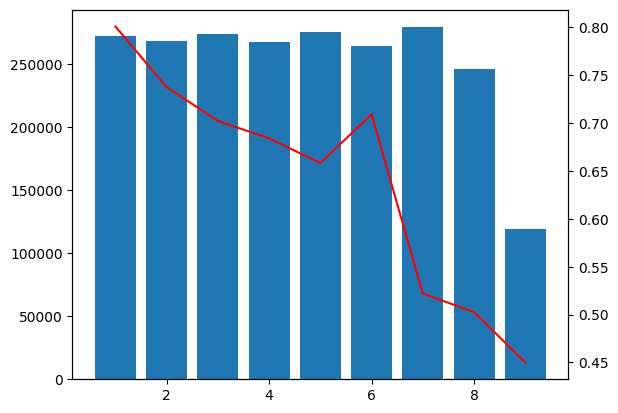

In [27]:
# test의 cat의 분포 및 정답률 그래프
fig,ax1 = plt.subplots()
ax1.bar(range(1,10), train.value_counts('test_cat').sort_index())
ax2 = ax1.twinx()
ax2.plot(range(1,10), train.groupby('test_cat')['answerCode'].mean(), c = 'red')
plt.show()

In [28]:
train = pd.read_csv('./data/train_data.csv')
test = pd.read_csv('./data/test_data.csv')
sub = pd.read_csv('./data/sample_submission.csv')

# 시간 차이(문제 푸는데 걸린 시간) 계산
train['Timestamp'] = pd.to_datetime(train['Timestamp'])
train['elapsed_time'] = train['Timestamp'].astype(int)
train['elapsed_time'] = train['elapsed_time'].diff().shift(-1) // 10**9

# 바뀌는 순간 포착 (testid, userid 둘중 하나가 바뀌는 순간 포착)
train['testId2'] = train['testId'].apply(lambda x: x[1:])
train['testId2'] = (train['testId2'] + train['userID'].astype(str)).astype(int)
train['changed_point'] = train['testId2'].diff().shift(-1)
train['changed_point'] = train['changed_point'].apply(lambda x: False if x == 0 else True)
train.drop('testId2', axis=1, inplace=True)

# 카테고리 컬럼 추가
train['test_cat'] = train['testId'].apply(lambda x: x[2])

# 문제 번호 컬럼 추가
train['question_number'] = train['assessmentItemID'].apply(lambda x: x[8:10]).map(int)

In [29]:
# elapsed_time이 너무 큰 경우, threshold를 걸어줄 수도 있다.
THRESHOLD_TIME = 200
train['elapsed_time_threshold'] = train['elapsed_time'].apply(lambda x: min(x, THRESHOLD_TIME))


# train data를 주어진 column에 대해서 groupby 하는 함수
def make_groupby(train: pd.DataFrame, group: str) -> pd.DataFrame:
    """
        answerCode: 정답률
        count: 행이 등장한 횟수
        time_mean: 걸린 시간 평균
        time_median: 걸린 시간 중간값
        time_threshold_mean: threshold 적용 후 평균
        time_threshold_median: threshold 적용 후 중간 값(time_median 이랑 동일할듯...)
    """
    df = train.groupby(group)['answerCode'].mean().to_frame()
    df['count'] = train.groupby(group)['answerCode'].count()

    # 시간에 대한 계산을 할 때는 제일 마지막 문제(시간 계산이 이상하게 나오는 경우)는 제외하고 계산한다.
    df['time_mean'] = train[~train['changed_point']].groupby(group)['elapsed_time'].mean()
    df['time_median'] = train[~train['changed_point']].groupby(group)['elapsed_time'].median()
    df['time_threshold_mean'] = train[~train['changed_point']].groupby(group)['elapsed_time_threshold'].mean()
    df['time_threshold_median'] = train[~train['changed_point']].groupby(group)['elapsed_time_threshold'].median()

    return df

exam = make_groupby(train, 'testId')
tag = make_groupby(train, 'KnowledgeTag')
problem = make_groupby(train, 'assessmentItemID')
category = make_groupby(train, 'test_cat')
problem_13 = make_groupby(train, 'question_number')
user = make_groupby(train, 'userID')


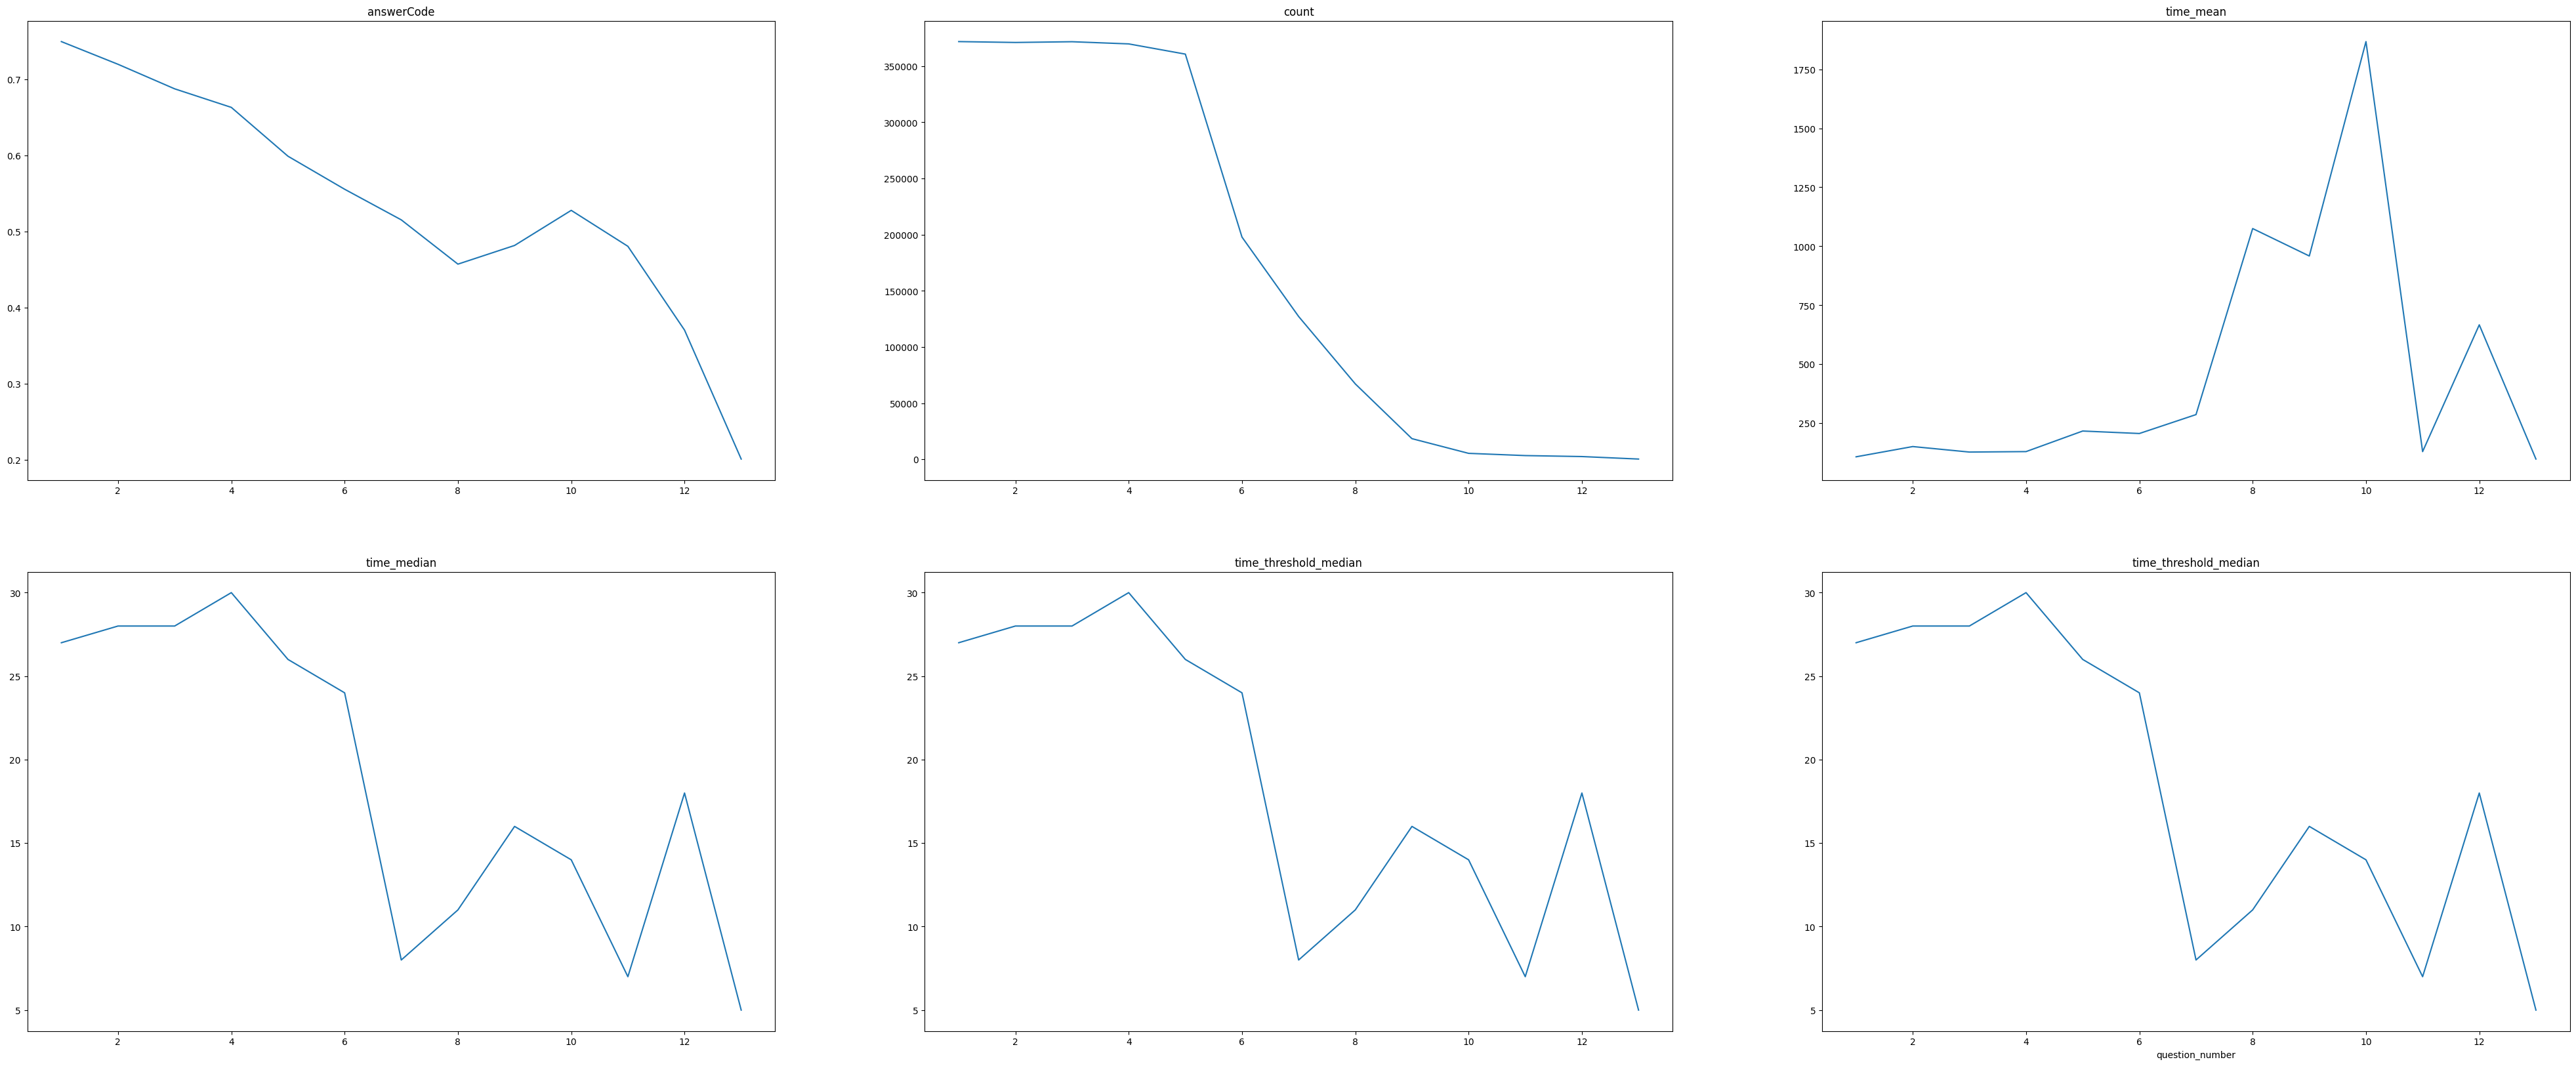

In [30]:
# 위에서 make_groupby로 만든 df들 그래프로 그려보기
def plot_multi(df: pd.DataFrame) -> None:
    fig, (axs) = plt.subplots(nrows=2, ncols=3, figsize=(50, 20))
    axs[0][0].plot(df['answerCode'])
    axs[0][0].set_title('answerCode')

    axs[0][1].plot(df['count'])
    axs[0][1].set_title('count')

    axs[0][2].plot(df['time_mean'])
    axs[0][2].set_title('time_mean')

    axs[1][0].plot(df['time_median'])
    axs[1][0].set_title('time_median')

    axs[1][1].plot(df['time_threshold_median'])
    axs[1][1].set_title('time_threshold_median')

    axs[1][2].plot(df['time_threshold_median'])
    axs[1][2].set_title('time_threshold_median')

    plt.xlabel(df.index.name)
    plt.show()

plot_multi(problem_13)

In [32]:
train = pd.read_csv('./data/train_data.csv')
test = pd.read_csv('./data/test_data.csv')
sub = pd.read_csv('./data/sample_submission.csv')

In [33]:
train["Timestamp"] = train["Timestamp"].astype("str")
date_info = train["Timestamp"].str.split(" ")

train["날짜"] = date_info.str.get(0)
train["시간"] = date_info.str.get(1)
dates = train["날짜"].str.split("-")
times = train["시간"].str.split(":")

train["year"] = dates.str.get(0)
train["month"] = dates.str.get(1)
train["day"] = dates.str.get(2)
train["hour"] = times.str.get(0)
train["minute"] = times.str.get(1)
train["second"] = times.str.get(2)

train["hour"] = train["hour"].astype(int)

In [34]:
train["year"].unique()

array(['2020', '2019'], dtype=object)

## 시간대별 문제 개수

<AxesSubplot: ylabel='hour'>

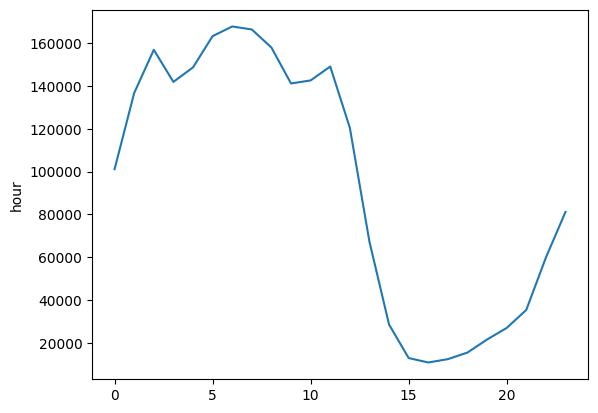

In [35]:
sns.lineplot(train['hour'].value_counts())

## 시간대별 정답률

<AxesSubplot: xlabel='hour', ylabel='answerCode'>

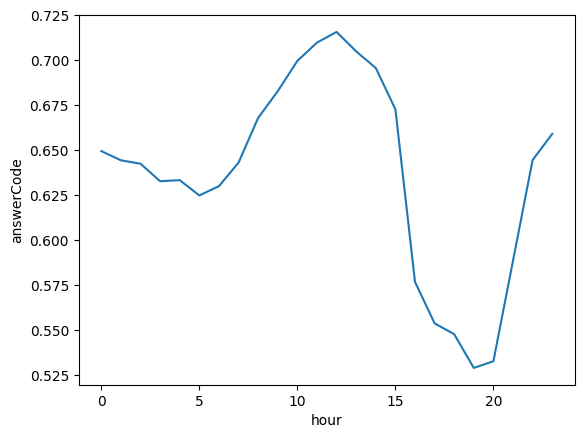

In [36]:
sns.lineplot(train.groupby("hour")["answerCode"].mean())

## 월별 정답률

<AxesSubplot: xlabel='month', ylabel='answerCode'>

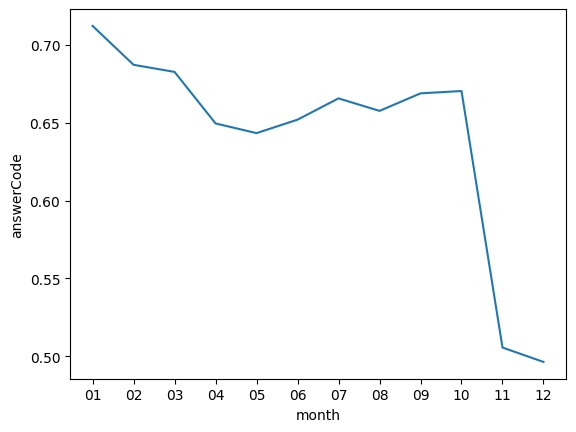

In [37]:
sns.lineplot(train.groupby("month")["answerCode"].mean())

## 월별 문제수

<AxesSubplot: ylabel='month'>

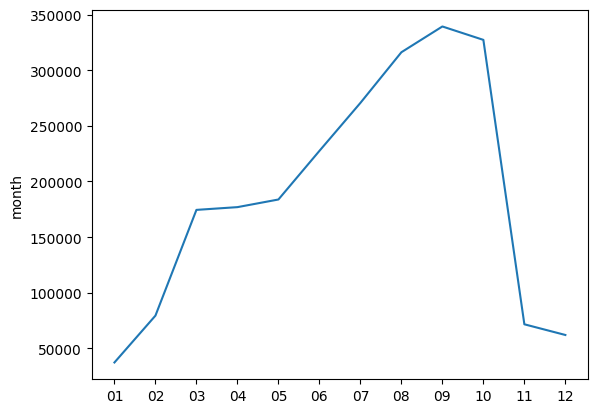

In [38]:
sns.lineplot(train['month'].value_counts().sort_index())

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns

In [42]:
train = pd.read_csv('./data/train_data.csv')

In [43]:
# 유저별 태그별 푼 문제 수
by_tag = train.groupby(['userID', 'KnowledgeTag'])['Timestamp'].count()
by_tag

userID  KnowledgeTag
0       23              4
        25              1
        26              7
        30              3
        31              1
                       ..
7440    7691            4
        10313           1
        10328           1
7441    438             5
        8836            4
Name: Timestamp, Length: 440802, dtype: int64

언뜻 보기엔 시간 순으로 정답률을 보기엔 문제 수가 너무 적어보인다. 가장 많이 푼 유저를 찾아 태그별 문제 수의 분포를 봐야겠다.

In [44]:
# 유저 별 푼 문제 수
train.groupby('userID')['assessmentItemID'].count().sort_values()

userID
7441       9
7390      13
7414      13
7252      13
7396      14
        ... 
926     1773
394     1774
1112    1777
481     1847
730     1860
Name: assessmentItemID, Length: 6698, dtype: int64

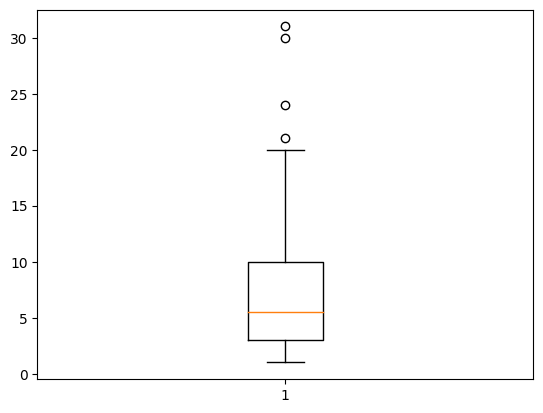

In [45]:
fig, ax = plt.subplots()
ax.boxplot(by_tag.loc[730])
plt.show()

문제를 가장 많이 푼 유저기준으로 보아도 시간별 정답률을 구하기엔 문제 수의 분포가 너무 적은 쪽에 몰려있는 듯 하다. 만약 문제를 얼마 풀지 않은 유저 기준으로는 더더욱이나 시간별 정답률을 구하기 힘들어보인다.

그래서 유저를 고려하지 않고 태그별 시간 순서 정답률을 구해보았다.

In [46]:
# 태그별 시간 순서 answerCode
by_tag = train.groupby(['KnowledgeTag', 'Timestamp'])['answerCode'].sum().to_frame()
by_tag

answerCode
KnowledgeTag Timestamp                      
23           2020-01-03 04:31:14           1
             2020-01-03 04:31:16           1
             2020-01-03 04:31:18           1
             2020-01-03 04:31:23           0
             2020-01-24 05:42:17           0
...                                      ...
11271        2020-09-02 13:14:02           0
             2020-09-15 05:49:57           1
             2020-09-17 09:29:41           1
             2020-09-21 10:03:17           1
             2020-10-11 04:09:14           0

[2261552 rows x 1 columns]

In [47]:
# 정답률을 구하기 위해 cumsum을 진행하며 total # of solved를 누적해줄 column 생성
by_tag['num_solved'] = 1
by_tag

answerCode  num_solved
KnowledgeTag Timestamp                                  
23           2020-01-03 04:31:14           1           1
             2020-01-03 04:31:16           1           1
             2020-01-03 04:31:18           1           1
             2020-01-03 04:31:23           0           1
             2020-01-24 05:42:17           0           1
...                                      ...         ...
11271        2020-09-02 13:14:02           0           1
             2020-09-15 05:49:57           1           1
             2020-09-17 09:29:41           1           1
             2020-09-21 10:03:17           1           1
             2020-10-11 04:09:14           0           1

[2261552 rows x 2 columns]

In [48]:
by_tag = by_tag.groupby(level=0).cumsum()
by_tag['accuracy'] = by_tag['answerCode'] / by_tag['num_solved']
by_tag

answerCode  num_solved  accuracy
KnowledgeTag Timestamp                                            
23           2020-01-03 04:31:14           1           1  1.000000
             2020-01-03 04:31:16           2           2  1.000000
             2020-01-03 04:31:18           3           3  1.000000
             2020-01-03 04:31:23           3           4  0.750000
             2020-01-24 05:42:17           3           5  0.600000
...                                      ...         ...       ...
11271        2020-09-02 13:14:02         230         518  0.444015
             2020-09-15 05:49:57         231         519  0.445087
             2020-09-17 09:29:41         232         520  0.446154
             2020-09-21 10:03:17         233         521  0.447217
             2020-10-11 04:09:14         233         522  0.446360

[2261552 rows x 3 columns]

In [49]:
# 가장 많이 풀린 태그 찾기
train.groupby('KnowledgeTag')['assessmentItemID'].count().sort_values()

KnowledgeTag
2613       44
7125       45
2871       46
4978       46
5142       47
        ...  
8127     9006
7621     9709
2010    10176
7600    10734
7597    12892
Name: assessmentItemID, Length: 912, dtype: int64

In [50]:
# 필요없는 column drop하고 가장 많이 풀린 태그 정보 불러와 저장
by_tag = by_tag.drop(['answerCode', 'num_solved'], axis=1)
by_tag_7597 = by_tag.loc[7597] ; by_tag_7597

,accuracy
Timestamp,
2020-01-03 03:07:39,1.000000
2020-01-03 03:14:46,1.000000
2020-01-03 03:15:13,1.000000
2020-01-03 05:48:24,1.000000
2020-01-03 05:48:56,1.000000
...,...
2020-10-10 12:40:29,0.828518
2020-10-15 08:50:55,0.828454
2020-10-15 08:51:09,0.828467


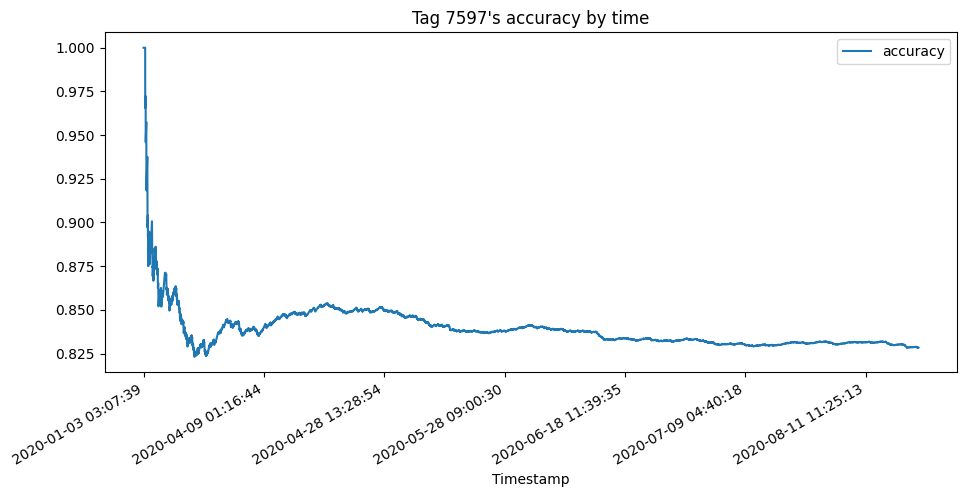

In [51]:
by_tag_7597.plot(figsize=(11, 5))

plt.title('Tag 7597\'s accuracy by time' )
plt.gcf().autofmt_xdate()
plt.show()

태그를 풀면 풀수록 모든 유저가 답을 계속 맞추지 않는 이상 정답률은 낮아질 수 밖에 없는 듯 하다.